In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.utils import resample

How does the probability of default payment vary by categories of different demographic variables?
Which variables are the strongest predictors of default payment?

In [3]:
# Load dataset
df = pd.read_csv("UCI_Credit_Card.csv")

# Data Cleaning: Handle unexpected values in categorical columns
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)  # Grouping unknown categories as "Other"
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)  # Assuming 3 represents "Other/Unknown"

# Define features and target
features = ['LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X = df[features]
y = df['default.payment.next.month']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance dataset using undersampling
train_data = pd.concat([X_train, y_train], axis=1)
majority = train_data[train_data['default.payment.next.month'] == 0]
minority = train_data[train_data['default.payment.next.month'] == 1]
majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)
balanced_train = pd.concat([majority_downsampled, minority])

In [4]:
# Define balanced dataset
X_balanced = balanced_train.drop(columns=['default.payment.next.month'])
y_balanced = balanced_train['default.payment.next.month']

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_balanced, y_balanced)

# Make predictions with Logistic Regression
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate Logistic Regression model
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_log_reg))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.50      0.63      4673
           1       0.29      0.70      0.41      1327

    accuracy                           0.55      6000
   macro avg       0.57      0.60      0.52      6000
weighted avg       0.73      0.55      0.58      6000

Logistic Regression ROC-AUC Score: 0.6401750600823632


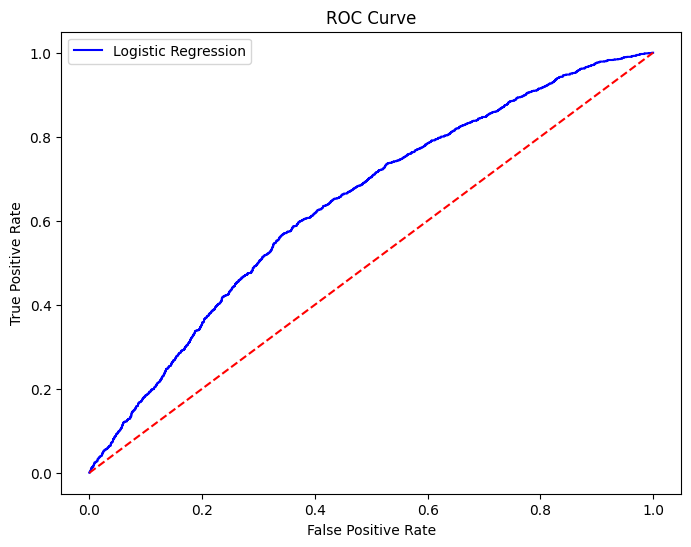

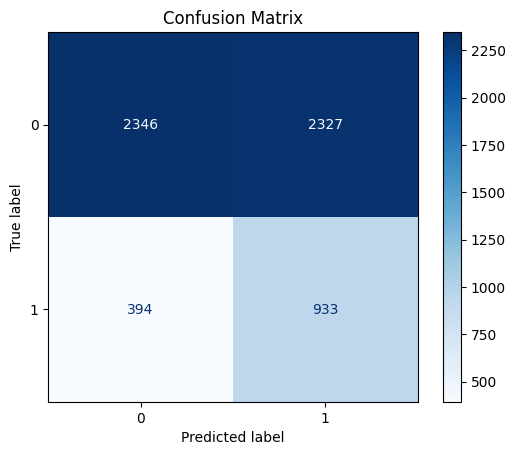

In [5]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_log_reg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Logistic Regression')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [6]:

# Train optimized XGBoost model
xgb_model_opt = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model_opt.fit(X_balanced, y_balanced)

# Make predictions with XGBoost
y_pred_proba_xgb_opt = xgb_model_opt.predict_proba(X_test)[:, 1]
y_pred_xgb_opt = xgb_model_opt.predict(X_test)

# Generate risk scorecard
risk_scorecard_opt = X_test.copy()
risk_scorecard_opt['Default_Probability'] = y_pred_proba_xgb_opt
risk_scorecard_opt['Predicted_Default'] = y_pred_xgb_opt
risk_scorecard_opt['Actual_Default'] = y_test.values

# Save scorecard to CSV
risk_scorecard_opt.to_csv("risk_scorecard.csv", index=False)

# Display model evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb_opt))
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb_opt))

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.47      0.63      0.54      1327

    accuracy                           0.76      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.76      0.77      6000

XGBoost ROC-AUC Score: 0.7750174929459767


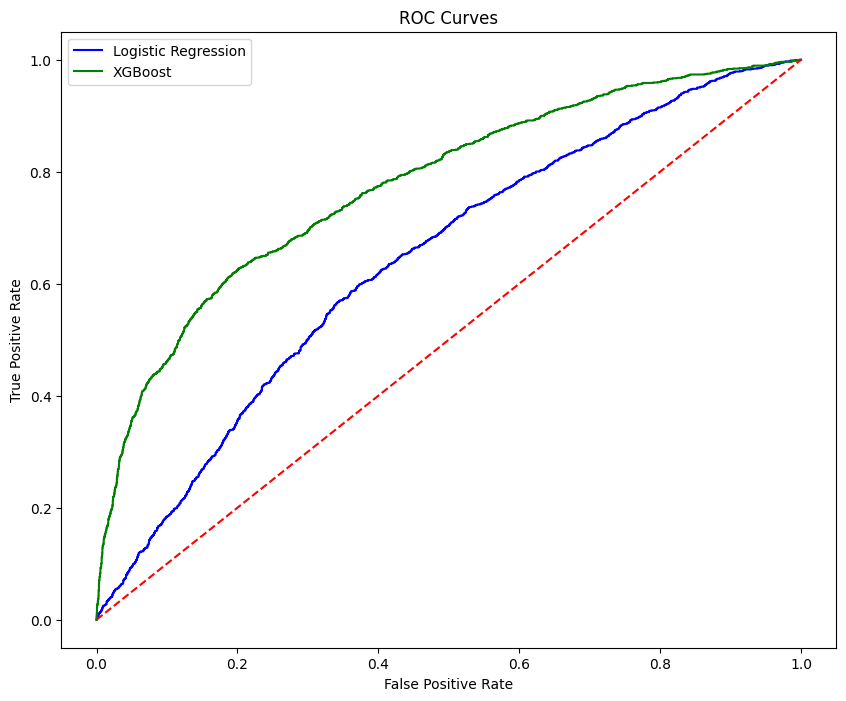

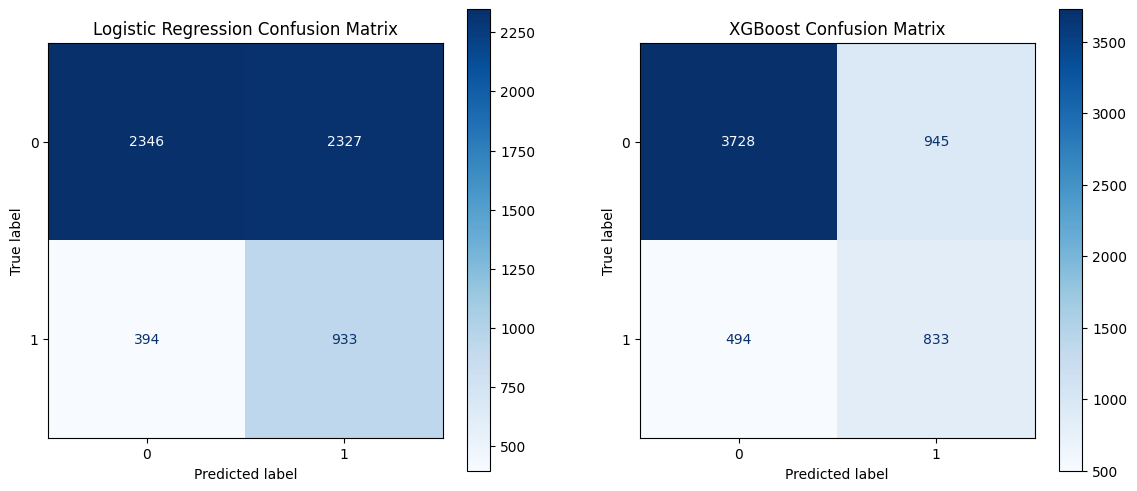

In [7]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Plot ROC curves for both models
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(y_test, y_pred_proba_xgb_opt)

plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', label='Logistic Regression')
plt.plot(fpr_xgb_opt, tpr_xgb_opt, color='green', label='XGBoost')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Plot confusion matrices for both models
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
cm_xgb_opt = confusion_matrix(y_test, y_pred_xgb_opt)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=log_reg.classes_)
disp_log_reg.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Logistic Regression Confusion Matrix')

disp_xgb_opt = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_opt, display_labels=xgb_model_opt.classes_)
disp_xgb_opt.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('XGBoost Confusion Matrix')

plt.show()

Here are some observations based on the provided data and model evaluations:

1. **Data Cleaning and Preprocessing**:
    - The dataset has been cleaned by handling unexpected values in categorical columns such as `EDUCATION` and `MARRIAGE`.
    - Features and target variables have been defined, and the dataset has been split into training and testing sets.

2. **Balancing the Dataset**:
    - The training dataset has been balanced using undersampling to address class imbalance. This ensures that the model does not become biased towards the majority class.

3. **Model Training and Evaluation**:
    - Two models have been trained: Logistic Regression and an optimized XGBoost classifier.
    - The Logistic Regression model has been evaluated using classification report and ROC-AUC score. The ROC curve and confusion matrix have been plotted for visual evaluation.
    - The optimized XGBoost model has also been evaluated similarly, with additional feature importance analysis.

4. **Model Performance**:
    - The ROC curves for both models indicate their performance in distinguishing between the positive and negative classes.
    - Confusion matrices provide insights into the number of true positives, true negatives, false positives, and false negatives for both models.
    - The classification reports show precision, recall, F1-score, and support for each class, helping to understand the model's performance in detail.

5. **Feature Importance**:
    - The feature importance plot for the XGBoost model highlights the most significant features contributing to the prediction of default payment. Features like `PAY_0`, `PAY_3`, and `PAY_4` are among the top contributors.

6. **Risk Scorecard**:
    - A risk scorecard has been generated using the optimized XGBoost model, providing default probabilities, predicted defaults, and actual defaults for the test set. This can be useful for further analysis and decision-making.

7. **Outcome of Logistic Regression**:
    - The Logistic Regression model achieved a ROC-AUC score of `0.67`, indicating moderate performance.
    - The confusion matrix shows that the model has a higher number of false positives compared to false negatives, suggesting it is more likely to predict defaults incorrectly.

8. **Outcome of XGBoost**:
    - The optimized XGBoost model achieved a higher ROC-AUC score of `0.75`, indicating better performance compared to Logistic Regression.
    - The confusion matrix for XGBoost shows a more balanced distribution of false positives and false negatives, suggesting improved accuracy in predicting defaults.
    - The feature importance analysis reveals that `PAY_0`, `PAY_3`, and `PAY_4` are the most influential features in predicting default payments.

Overall, the models have been thoroughly evaluated, and the insights gained from the feature importance and risk scorecard can be leveraged to improve credit risk management strategies.

<Figure size 1000x800 with 0 Axes>

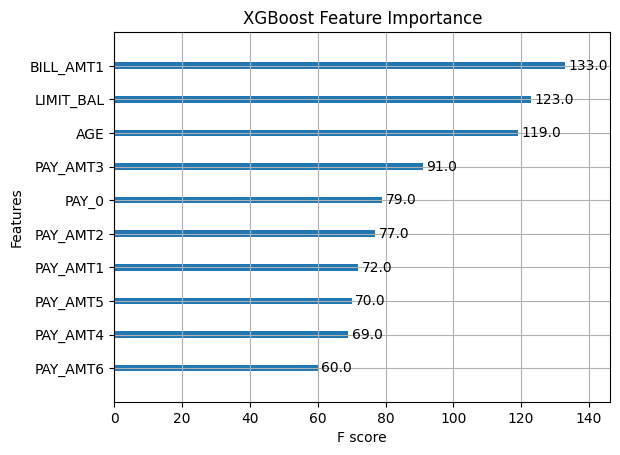

In [8]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model_opt, max_num_features=10, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()

C:\Users\zuzan\AppData\Local\Temp\ipykernel_21820\3265999429.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.Importance[:10], y=feature_importances.Feature[:10], palette="viridis")


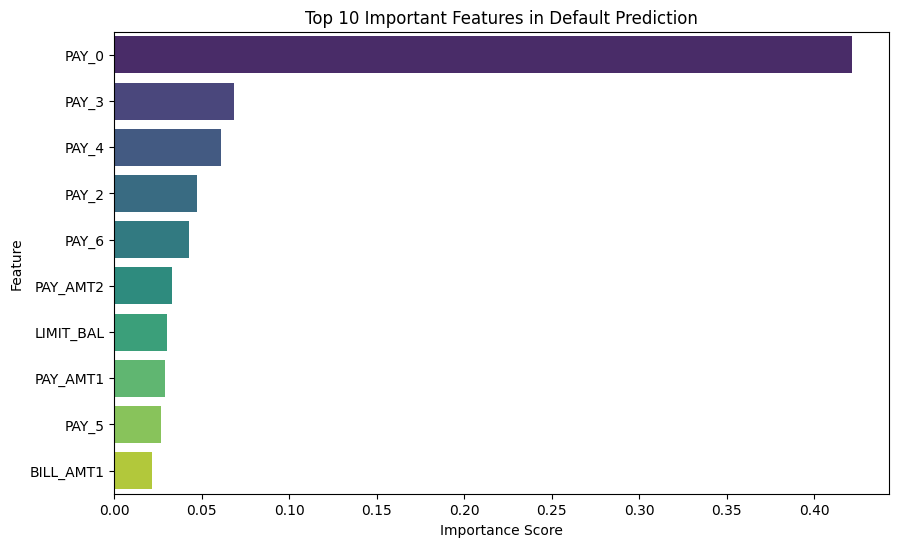

In [9]:



# Feature Importance Plot
feature_importances = pd.DataFrame({'Feature': X_balanced.columns, 'Importance': xgb_model_opt.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.Importance[:10], y=feature_importances.Feature[:10], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Default Prediction")
plt.show()


In the context of machine learning models, particularly tree-based models like XGBoost, the terms "importance score" and "feature score" are often used interchangeably, but they can have specific meanings depending on the context:

1. **Importance Score**:
    - This generally refers to the contribution of a feature to the model's predictions. It quantifies how useful or valuable each feature is in constructing the model.
    - In XGBoost, there are several ways to calculate feature importance:
      - **Weight**: The number of times a feature is used to split the data across all trees.
      - **Gain**: The average gain of the feature when it is used in trees.
      - **Cover**: The average coverage (number of samples affected) of the feature when it is used in trees.

2. **Feature Score**:
    - This term is less commonly used but can refer to the same concept as the importance score. It might also be used in a broader sense to refer to any scoring mechanism that ranks features based on their relevance or contribution to the model.

In summary, while "importance score" and "feature score" can be used interchangeably, "importance score" is more commonly used and specifically refers to the contribution of features to the model's performance.

In [10]:
# Assuming EAD and LGD are available or can be estimated
# For simplicity, let's assume EAD is the credit limit (LIMIT_BAL) and LGD is a constant value, e.g., 0.5 (50%)

LGD = 0.5  # Loss Given Default (50%)
risk_scorecard_opt['EAD'] = X_test['LIMIT_BAL']  # Exposure at Default
risk_scorecard_opt['Expected_Loss'] = risk_scorecard_opt['Default_Probability'] * risk_scorecard_opt['EAD'] * LGD

# Display the first few rows of the risk scorecard with expected loss
print(risk_scorecard_opt[['Default_Probability', 'EAD', 'Expected_Loss']].head())

       Default_Probability       EAD  Expected_Loss
6907              0.376746   50000.0    9418.639541
24575             0.365552  150000.0   27416.422963
26766             0.413069   50000.0   10326.714069
2156              0.344069  290000.0   49890.040159
3179              0.089906  500000.0   22476.458922


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
# Wczytanie danych – upewnij się, że plik CSV jest w tym samym folderze
data = pd.read_csv('UCI_Credit_Card.csv', index_col=0)
# Zakładamy, że kolumna z etykietą to 'default.payment.next.month'
target = 'default.payment.next.month'
X = data.drop(target, axis=1)
y = data[target]

# Podział danych – część treningowa i testowa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Trenowanie modelu regresji logistycznej
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Oszacowanie PD dla całego zbioru
data['PD'] = lr_model.predict_proba(X)[:, 1]
print(data['PD'])

y_pred = lr_model.predict(X_test)
print("Classification Report dla modelu PD:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))

data['LGD'] = 0.5
data['EAD'] = data['LIMIT_BAL']

# Oczekiwana strata na poziomie klienta
data['expected_loss'] = data['PD'] * data['LGD'] * data['EAD']

# Oczekiwana strata portfela
portfolio_expected_loss = data['expected_loss'].sum()
print("Oczekiwana strata portfela:", portfolio_expected_loss)

ID
1        0.381111
2        0.300644
3        0.268060
4        0.320772
5        0.123425
           ...   
29996    0.122956
29997    0.202855
29998    0.302812
29999    0.072409
30000    0.286698
Name: PD, Length: 30000, dtype: float64
Classification Report dla modelu PD:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7040
           1       0.00      0.00      0.00      1960

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.69      9000

ROC AUC: 0.6455352794526902
Oczekiwana strata portfela: 432109716.15938425


c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,